#### 神經網路建置

In [57]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化  權重初始化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成  產生各層。  !!!使用有序的字典
        self.layers = OrderedDict()  
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])  # 計算權重訊號乘積的總和
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])  # 計算權重訊號乘積的總和

        self.lastLayer = SoftmaxWithLoss()  # 神經網路的最後一層，即SoftmaxWithLoss
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ 輸入資料, t:教師データ  訓練(實際)資料
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ 輸入資料, t:教師データ  訓練(實際)資料
    #  正向傳播法
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    # 反向傳播法   
    def gradient(self, x, t):    # 這邊的各層layer是有順序的。會依照正確順序連結各層 ，並依序呼叫出各層
        # forward
#         self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads


#### 梯度確認
- 比對正向(numerical_gradient)與反向傳播法(gradient)求得的參數差異）(W, B)

In [52]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 計算各權重的絕對誤差平均值
for key in grad_numerical.keys():   # keys:['W1', 'b1', 'W2', 'b2']
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:5.317899085505503e-10
b1:2.9219856313429487e-09
W2:7.259828646541757e-09
b2:1.3978575178763553e-07


In [71]:
%timeit

# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100               # Iterations = train_size / batch_size => 600
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 利用反向誤差傳播法計算梯度
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'{i:>4d} - train_acc : {train_acc:.3f}; train_acc : {test_acc:.3f}')

 

   0 - train_acc : 0.117; train_acc : 0.119
 600 - train_acc : 0.903; train_acc : 0.907
1200 - train_acc : 0.919; train_acc : 0.922
1800 - train_acc : 0.934; train_acc : 0.933
2400 - train_acc : 0.938; train_acc : 0.939
3000 - train_acc : 0.950; train_acc : 0.946
3600 - train_acc : 0.954; train_acc : 0.953
4200 - train_acc : 0.959; train_acc : 0.956
4800 - train_acc : 0.959; train_acc : 0.955
5400 - train_acc : 0.965; train_acc : 0.960
6000 - train_acc : 0.968; train_acc : 0.964
6600 - train_acc : 0.970; train_acc : 0.965
7200 - train_acc : 0.972; train_acc : 0.966
7800 - train_acc : 0.973; train_acc : 0.966
8400 - train_acc : 0.974; train_acc : 0.968
9000 - train_acc : 0.976; train_acc : 0.969
9600 - train_acc : 0.977; train_acc : 0.969


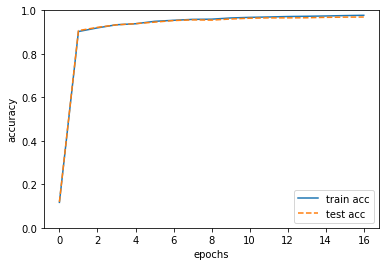

In [73]:
import matplotlib.pyplot as plt
# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 大約在epoch 2~5之間預測結果即收斂